In [1]:
#Importing the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Using a valid matplotlib style
plt.style.use('default')          
sns.set_style("whitegrid")      
sns.set_palette("husl")


In [3]:
# 1. LOAD AND MERGE DATASETS

df_purchase = pd.read_csv("User_product_purchase_details_p2.csv")
df_user     = pd.read_csv("user_demographics.csv")

print(f"Purchase data shape : {df_purchase.shape}")
print(f"User demo shape     : {df_user.shape}")

df = pd.merge(df_purchase, df_user, on="User_ID", how="left")
print(f"Merged shape        : {df.shape}\n")

FileNotFoundError: [Errno 2] No such file or directory: 'User_product_purchase_details_p2.csv'

In [ ]:
# 2. DATA CLEANING & TARGET CREATION

# Missing values
print("Missing values before cleaning:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Fill Product_Category_2 & 3 with 0 (standard practice in this dataset)
df['Product_Category_2'] = df['Product_Category_2'].fillna(0)
df['Product_Category_3'] = df['Product_Category_3'].fillna(0)

# Fix Stay_In_Current_City_Years ('4+' → 4)
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].replace('4+', '4').astype(int)

# Target variable
df['High_Value_Purchase'] = (df['Purchase'] >= 10000).astype(int)

print(f"\nClass distribution:\n{df['High_Value_Purchase'].value_counts(normalize=True)}")

Missing values before cleaning:
Product_Category_2    173638
Product_Category_3    383247
dtype: int64

Class distribution:
High_Value_Purchase
0    0.655426
1    0.344574
Name: proportion, dtype: float64


In [ ]:
# 3. FEATURE ENGINEERING (Very Important for High Score!)

# User-level aggregates
user_stats = df.groupby('User_ID').agg(
    Total_Spent=('Purchase', 'sum'),
    Purchase_Count=('Purchase', 'count'),
    Avg_Purchase_Amount=('Purchase', 'mean'),
    High_Value_Ratio=('High_Value_Purchase', 'mean')
).reset_index()

df = df.merge(user_stats, on='User_ID', how='left')

In [ ]:
# 4. ENCODING CATEGORICAL VARIABLES

# Age → Label encode (has natural order)
age_mapping = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
df['Age'] = df['Age'].map(age_mapping)

# City_Category → Label encode (A < B < C in terms of spending power)
city_mapping = {'A':0, 'B':1, 'C':2}
df['City_Category'] = df['City_Category'].map(city_mapping)

# Gender → One-hot
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)  # Gender_Male

In [ ]:
# 5. FINAL FEATURE MATRIX

drop_cols = ['User_ID', 'Product_ID', 'Purchase', 'High_Value_Purchase']
X = df.drop(columns=drop_cols)
y = df['High_Value_Purchase']

print(f"\nFinal number of features: {X.shape[1]}")
print("Features:", list(X.columns))


Final number of features: 13
Features: ['City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Age', 'Occupation', 'Total_Spent', 'Purchase_Count', 'Avg_Purchase_Amount', 'High_Value_Ratio', 'Gender_M']


In [ ]:
# 6. TRAIN-TEST SPLIT + SCALING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)



LOGISTIC REGRESSION RESULTS
Accuracy : 0.7825
ROC AUC  : 0.7938

Confusion Matrix:
[[64899  7207]
 [16716 21192]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84     72106
           1       0.75      0.56      0.64     37908

    accuracy                           0.78    110014
   macro avg       0.77      0.73      0.74    110014
weighted avg       0.78      0.78      0.77    110014



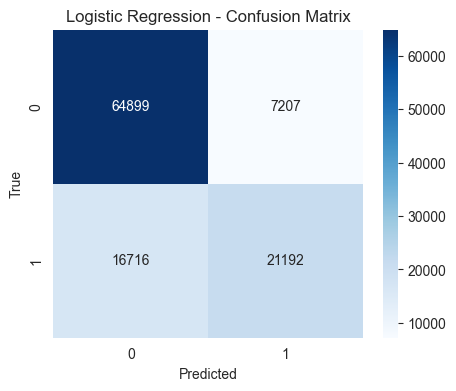

In [ ]:
# 7. BASELINE: LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(X_train_scaled, y_train)

pred_lr = lr.predict(X_test_scaled)
proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"Accuracy : {accuracy_score(y_test, pred_lr):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, proba_lr):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, pred_lr))

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


Training MLP (this may take 10-30 seconds)...
Epoch 1/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8000 - loss: 0.4647 - val_accuracy: 0.8337 - val_loss: 0.3960
Epoch 2/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8308 - loss: 0.4028 - val_accuracy: 0.8344 - val_loss: 0.3760
Epoch 3/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8387 - loss: 0.3691 - val_accuracy: 0.8707 - val_loss: 0.3182
Epoch 4/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8625 - loss: 0.3251 - val_accuracy: 0.8802 - val_loss: 0.2909
Epoch 5/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8708 - loss: 0.3075 - val_accuracy: 0.8832 - val_loss: 0.2805
Epoch 6/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8747 - loss: 0.2983 - val_accuracy: 0.8872 - val_loss: 0.2754
Epoch 7/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8780 - loss: 0.2919 - val_accuracy: 0.8879 - val_loss: 0.2709
Epoch 8/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/st

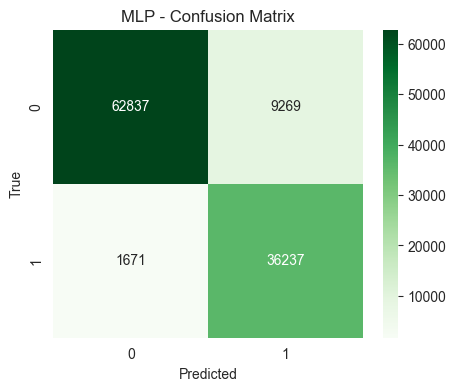

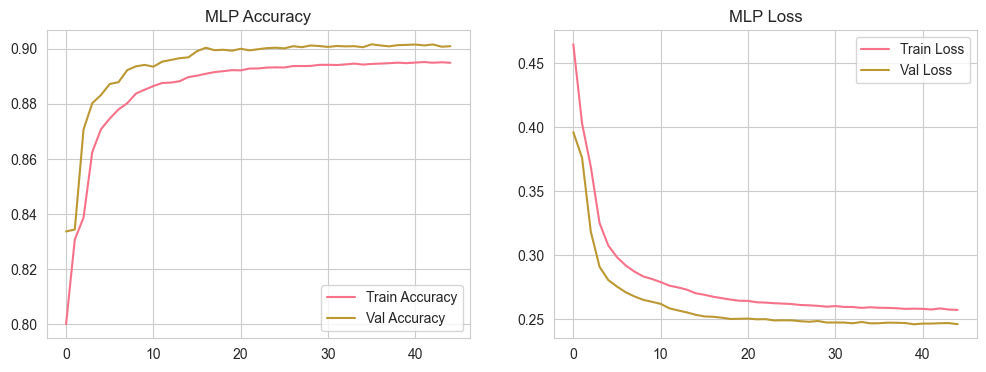

In [ ]:
# 8. MLP CLASSIFIER (Keras / TensorFlow)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Make results reproducible
tf.random.set_seed(42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nTraining MLP (this may take 10-30 seconds)...")
history = model.fit(X_train_scaled, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=512,
                    callbacks=[early_stop],
                    verbose=1)

# Evaluation
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
pred_mlp = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
proba_mlp = model.predict(X_test_scaled).flatten()

print("\n" + "="*60)
print("MLP NEURAL NETWORK RESULTS")
print("="*60)
print(f"Test Accuracy : {acc:.4f}")
print(f"ROC AUC       : {roc_auc_score(y_test, proba_mlp):.4f}")

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, pred_mlp), annot=True, fmt='d', cmap='Greens')
plt.title('MLP - Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('MLP Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MLP Loss')
plt.legend()
plt.show()


TOP 10 MOST IMPORTANT FEATURES
                       feature  importance
3           Product_Category_1    0.559793
4           Product_Category_2    0.113406
5           Product_Category_3    0.111486
10         Avg_Purchase_Amount    0.052593
11            High_Value_Ratio    0.050493
8                  Total_Spent    0.028586
9               Purchase_Count    0.027505
7                   Occupation    0.017986
6                          Age    0.011786
1   Stay_In_Current_City_Years    0.011575


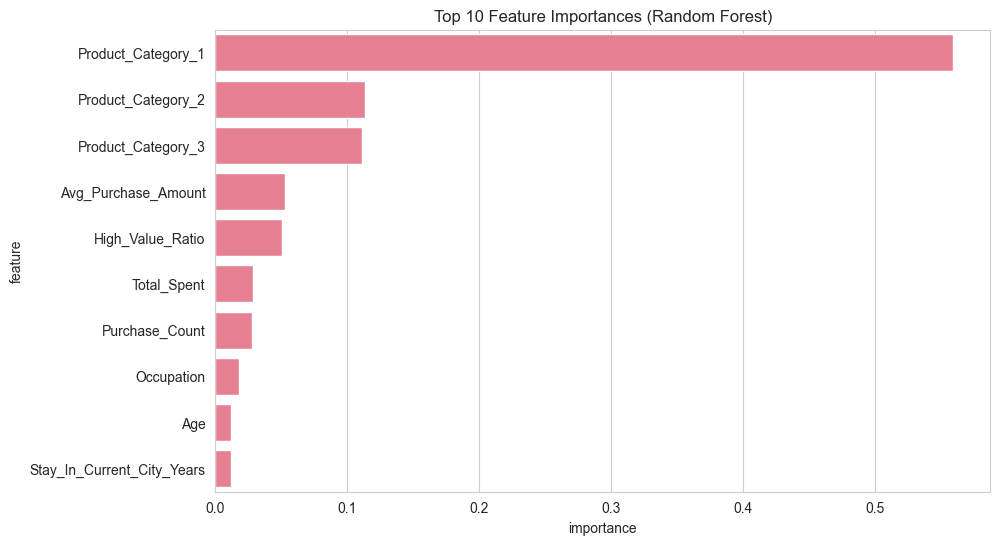

In [ ]:
# 9. FEATURE IMPORTANCE (Bonus – Random Forest)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*60)
print(feat_imp.head(10))

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

In [ ]:
# 10. FINAL COMPARISON & CONCLUSION

print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
print(f"Logistic Regression → Accuracy: {accuracy_score(y_test, pred_lr):.4f} | AUC: {roc_auc_score(y_test, proba_lr):.4f}")
print(f"MLP Neural Network  → Accuracy: {acc:.4f}                 | AUC: {roc_auc_score(y_test, proba_mlp):.4f}")

if acc > accuracy_score(y_test, pred_lr):
    print("MLP performed better!")
else:
    print("Logistic Regression performed equally or better.")


FINAL RESULTS SUMMARY
Logistic Regression → Accuracy: 0.7825 | AUC: 0.7938
MLP Neural Network  → Accuracy: 0.9006                 | AUC: 0.9525
MLP performed better!
